In [1]:
from ephys_queries import select_analog_signal_data, select_spike_times, select_stft
from ephys_queries import db_setup_core
from dotenv import load_dotenv
from pathlib import Path

In [2]:
from spiketimes.df.statistics import ifr_by
from spiketimes.df.binning import which_bin
from spiketimes.utils import p_adjust

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations
from scipy.stats import zscore

In [4]:
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, fftfreq
from scipy import signal

In [250]:
def db_normalise(x, ref):
    return 10 * np.log10(x / ref)


def frequency_heatmap(df, 
                      frequency_col="frequency", 
                      data_col="fft_value", 
                      time_col="timepoint_s",
                      vmin=None, vmax=None,
                      sigma=1,
                      figsize=(10, 5),
                      zscore_norm=False,
                      db_norm=True,
                      ax=None, 
                      imshow_kwargs=None
                     ):
    if imshow_kwargs is None:
        imshow_kwargs={}
    imshow_kwargs["cmap"] = "coolwarm" if "cmap" not in imshow_kwargs else imshow_kwargs["cmap"]
    imshow_kwargs["aspect"] = "auto" if "aspect" not in imshow_kwargs else imshow_kwargs["aspect"]
    if ax is None:
        f, ax = plt.subplots(figsize=figsize)
    dfp = (
        df
        .pivot(
            index=time_col,
            columns=frequency_col,
            values=data_col,
        )
    )
    dfp = pd.DataFrame(gaussian_filter(dfp.values, sigma))
    if db_norm:
        dfp = dfp.apply(lambda x: db_normalise(x, x.iloc[:len(x)//4].mean()))
    if zscore_norm:
        dfp = dfp.apply(zscore)
    dfp = dfp.transpose()

    im = ax.imshow(dfp.iloc[::-1], vmin=vmin, vmax=vmax, **imshow_kwargs)

    # xticks
    n = dfp.shape[1]
    first_point = df[time_col].min() 
    time_interval = df.iloc[:5, :][time_col].diff().values[1]
        
    xticks = np.arange(0, n, (60 / time_interval) * 10)    
    ax.set_xticks(xticks)
    ax.set_xticklabels( first_point + xticks // (60 / time_interval))
    

    # yticks
#     max_f = df[frequency_col].max()
#     min_f = df[frequency_col].min()
#     f = df[frequency_col].unique()[:5]
#     f.sort()
#     f_interval = np.diff(f)[1]

#     ytick_labels = np.round(np.linspace(min_f, max_f, 5))
#     yticks = np.arange(0, dfp.shape[0])
#     yticks = yticks[np.isin(yticks, min_f +(ytick_labels / f_interval))]
#     ax.set_yticks(yticks)
#     ax.set_yticklabels(ytick_labels[::-1])

    plt.colorbar(im)
    return ax

def fourier(sig, fs, n=None):
    if n is None:
        n = len(sig)
    sigX = fft(sig, n)
    sigX = sigX / n
    f = fftfreq(n, 1/fs)
    return sigX[f >= 0], f[f >= 0]

def butter(f, btype, fs, order=7):
    if hasattr(f, '__iter__') and not isinstance(f, np.ndarray):
        f = np.array(f)
    nyq = np.round(fs / 2)
    f = f / nyq
    b, a = signal.butter(order, f, btype=btype)
    return b, a

def iir_impulse_response(b, a, fs):
    impulse = np.concatenate([np.zeros((1, 50000)).flatten(), np.array([1]), np.zeros((1, 50000)).flatten()])
    filtered = signal.filtfilt(b, a, impulse)
    fX, ff = fourier(filtered, fs)
    return filtered, fX, ff

# Load and Export

In [6]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [10]:
dfb = pd.read_csv(data_dir / "baseline.csv")

In [11]:
group_names = ["acute_citalopram", 
            "acute_saline", 
            "acute_cit", 
            "acute_sal",
              "shock",
              "sham"]
signal_names = ["eeg_occ", "eeg_fr", "eeg_fl"]

block_name = "pre"
load_dotenv()
engine, metadata = db_setup_core()

In [12]:
# df_fft = select_stft(engine, metadata, 
#                                signal_names=signal_names,
#                               block_name=block_name, 
#                               group_names=group_names
#                                    )
# df_fft.to_parquet(data_dir / "eeg_stft.parquet.gzip", compression="gzip", index=False)

In [9]:
# df_eeg_analog = select_analog_signal_data(engine, metadata, 
#                                signal_names=signal_names,
#                               block_name=block_name, 
#                               group_names=group_names
#                                    )
# df_eeg_analog.to_parquet(data_dir / "df_eeg_analog.parquet.gzip", compression="gzip", index=False)

In [111]:
df_eeg_analog = pd.read_parquet(data_dir / "df_eeg_analog.parquet.gzip")

In [112]:
df_fft = pd.read_parquet(data_dir / "eeg_stft.parquet.gzip")

In [238]:
session = df_eeg_analog.session_name.unique()[-6]

In [239]:
session_names = [session]

df = (
    df_eeg_analog
    .loc[lambda x: x.session_name.isin(session_names)]
    .pivot_table(index=["timepoint_s", "session_name"], columns="signal_name", values="voltage")
    .reset_index()
    .rename_axis(None, axis=1)
    .assign(
        ref = lambda x: np.nanmean(x.loc[:, ["eeg_fr", "eeg_fl", "eeg_occ"]], axis=1),
        eeg_fl_car= lambda x: x.eeg_fl - x.ref,
        eeg_fr_car= lambda x: x.eeg_fl - x.ref,
        eeg_occ_car= lambda x: x.eeg_fl - x.ref,
           )
)

In [252]:
df1 = (
    df_fft
    .loc[lambda x: x.session_name == session]
    .loc[lambda x: (x.frequency >= 0.5) & (x.frequency < 15)]
)

In [241]:
session

'hamilton_10'

# Plot Raw EEG Data

## Delta

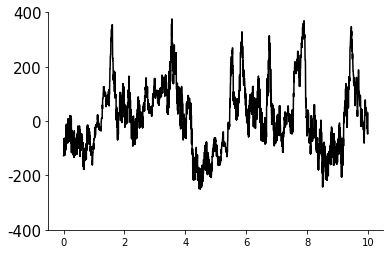

In [362]:
num_secs = 10
t_start = 9 * 67
t_stop = t_start + num_secs


y2 = (
    df
    .loc[lambda x: (x.timepoint_s >= t_start) & (x.timepoint_s < t_stop)]
#     .iloc[::4]
    .eeg_occ
    .values
)

yp = median_filter(y2, size=4)
x = np.linspace(0, num_secs, len(y2))

f, ax = plt.subplots()


ax.plot(x, yp, color="black")
sns.despine()
ax.set_ylim([-400, 400])
ax.set_yticks([-400, -200, 0, 200, 400])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)

plt.savefig(fig_dir / "nonactivated_eeg.svg")

## Theta

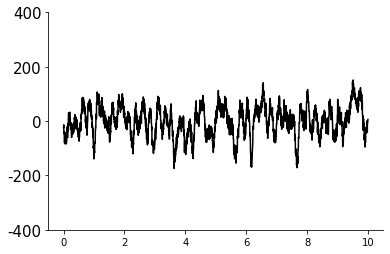

In [364]:
from scipy.ndimage import median_filter

num_secs = 10
t_start = 25 * 61
t_stop = t_start + num_secs


y2 = (
    df
    .loc[lambda x: (x.timepoint_s >= t_start) & (x.timepoint_s < t_stop)]
    .iloc[::]
    .eeg_occ_car
    .values
)

yp = median_filter(y2, size=3)

x = np.linspace(0, num_secs, len(y2))

f, ax = plt.subplots()

ax.plot(x, yp, color="black")
# ax.set_xticks([0, 5])
# ax.set_xticklabels( ax.get_xticks(), fontsize=15)
ax.set_ylim([-400, 400])
ax.set_yticks([-400, -200, 0, 200, 400])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)

sns.despine()
plt.savefig(fig_dir / "activate_eeg.svg")

# Plot Frequncy Domain Data

In [366]:
df

,timepoint_s,session_name,eeg_fl,eeg_fr,eeg_occ,ref,eeg_fl_car,eeg_fr_car,eeg_occ_car
0,0.004,hamilton_10,22.085763,176.790808,76.566354,91.814308,-69.728545,-69.728545,-69.728545
1,0.008,hamilton_10,52.738738,373.427408,188.506103,204.890750,-152.152011,-152.152011,-152.152011
2,0.012,hamilton_10,109.471712,390.007112,226.876267,242.118364,-132.646652,-132.646652,-132.646652
3,0.016,hamilton_10,91.307321,405.458417,205.055487,233.940408,-142.633087,-142.633087,-142.633087
4,0.020,hamilton_10,99.025342,395.086781,188.916959,227.676361,-128.651018,-128.651018,-128.651018
...,...,...,...,...,...,...,...,...,...
450136,1800.548,hamilton_10,-28.485285,0.805060,-15.496281,-14.392169,-14.093117,-14.093117,-14.093117
450137,1800.552,hamilton_10,11.361379,-0.395402,7.006115,5.990697,5.370682,5.370682,5.370682
450138,1800.556,hamilton_10,-6.600269,0.370487,-4.161980,-3.463921,-3.136348,-3.136348,-3.136348
450139,1800.560,hamilton_10,4.253717,-0.163937,2.756916,2.282232,1.971485,1.971485,1.971485


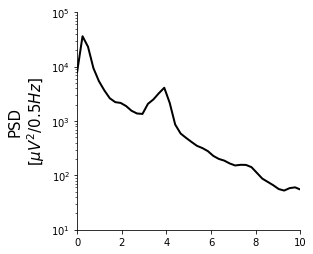

In [390]:

f, ax = plt.subplots(figsize=(4, 4))
f, Pxx_den = signal.welch(df.eeg_occ, 250, nperseg=1024)

plt.semilogy(f, Pxx_den, color="black", linewidth=2)
plt.xlim(0.5, 40)
sns.despine()
plt.xlim([0, 10])

plt.ylim([10, 10e4])
plt.ylabel("PSD\n$[\mu V^2/0.5 Hz]$", fontsize=15,)

plt.savefig(fig_dir / "stationary_eeg_occ.svg")

In [ ]:
f, ax = plt.subplots(figsize=(4, 4))
f, Pxx_den = signal.welch(df.eeg_fr_car, 250, nperseg=1024)

plt.semilogy(f, Pxx_den, color="black", linewidth=2)
plt.xlim(0.5, 40)
sns.despine()
plt.xlim([0, 10])

plt.ylim([10, 10e4])
plt.ylabel("PSD\n$[\mu V^2/0.5 Hz]$", fontsize=15,)

# Plot Time Frequency Data

In [356]:
session = df_fft.session_name.unique()[1]

df1 = (
    df_fft
    .loc[lambda x: x.session_name == session]
    .loc[lambda x: (x.frequency >= 0.5) & (x.frequency < 8)]
)

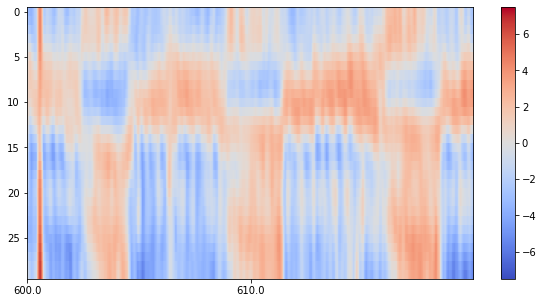

In [360]:
dfp = (
    df1
    .loc[lambda x: x.signal_name == "eeg_occ"]
    .loc[lambda x: (x.timepoint_s >= 10 * 60) & (x.timepoint_s < 30 * 60)]
)

frequency_heatmap(dfp, frequency_col="frequency", 
                      data_col="fft_value", 
                      time_col="timepoint_s",
                      vmin=-7.5, vmax=7.5,
                      sigma=2,
                      figsize=(10, 5),
                      zscore_norm=False,
                      db_norm=True,
                      ax=None, 
                      imshow_kwargs=None
                     )
plt.savefig(fig_dir / "timefrequency.svg")

In [17]:
df_fft

,frequency,fft_value,session_name,signal_name,timepoint_s,group_name
0,0.0,6.800059,acute_15,eeg_fr,2.0,acute_saline
1,0.0,255.546662,acute_15,eeg_fr,4.0,acute_saline
2,0.0,102.846310,acute_15,eeg_fr,6.0,acute_saline
3,0.0,213.964265,acute_15,eeg_fr,8.0,acute_saline
4,0.0,298.966096,acute_15,eeg_fr,10.0,acute_saline
...,...,...,...,...,...,...
39289417,125.0,0.140906,hamilton_32,eeg_fr,1794.0,acute_sal
39289418,125.0,0.070273,hamilton_32,eeg_fr,1796.0,acute_sal
39289419,125.0,0.052067,hamilton_32,eeg_fr,1798.0,acute_sal
39289420,125.0,0.173253,hamilton_32,eeg_fr,1800.0,acute_sal
